# Streaming

## Review

In module 2, dove into state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact with agents. 

To set the stage for `human-in-the-loop`, we're going to first cover streaming. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show how this can be used with streaming.

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

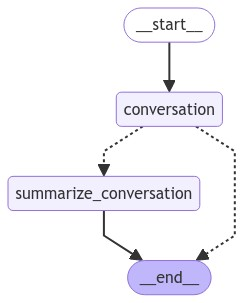

In [2]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

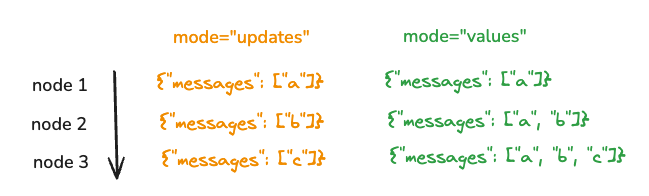

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after each step of the graph.

Each `chunk` is a dict with `node_name` has the key and the updated state as the value.

In [3]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-4654ad58-a7e1-4a07-9fdc-f2347087e8bd-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21})}}


Let's now just print the state update.

In [4]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Lance! It's great to meet you. How can I help you today?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [5]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! How can I assist you today?
---------------------------------------------------------------------------


### Streaming tokens

But, we often want to stream more than state.

In particular, with LLM calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Which contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [6]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_65617/946416104.py:3: LangChainBetaWarning: This API is in beta and may change in the future.
  async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):


Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: 

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "111"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content='The', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content=' San', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content=' Francisco', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content=' ', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content='49', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content='ers', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content=' are', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content=' a', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content=' professional', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMessageChunk(content=' American', id='run-c279910f-0d59-4556-8ab9-571c4069ca2a')}
{'chunk': AIMe

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [8]:
config = {"configurable": {"thread_id": "222"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| of| the| league|'s| National| Football| Conference| (|N|FC|)| West| division|.| Here| are| some| key| points| about| the| team|:

|###| History|
|-| **|Founded|:**| |194|6| as| a| charter| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| when| the| leagues| merged|.
|-| **|Team| Name|:**| The| name| "|49|ers|"| is| a| reference| to| the| prospect|ors| who| arrived| in| Northern| California| during| the| |184|9| Gold| Rush|.

|###| Ach|ievements|
|-| **|Super| Bowl| Championships|:**| The| |49|ers| have| won| five| Super| Bowl| titles| (|X|VI|,| XIX|,| XX|III|,| XX|IV|,| and| XX|IX|).
|-| **|Conference| Championships|:**| They| have| won| seven| NFC| championships|.
|-| **|Division| Championships|:**| The| team| has| numerous| NFC| West| di

### Streaming with LangGraph API

Our Chatbot is running locally in Studio. 

The LangGraph API serves as the back-end for Studio.

We can interact directly with the API via the LangGraph SDK.

Let's get the URL for the local deployment from Studio.

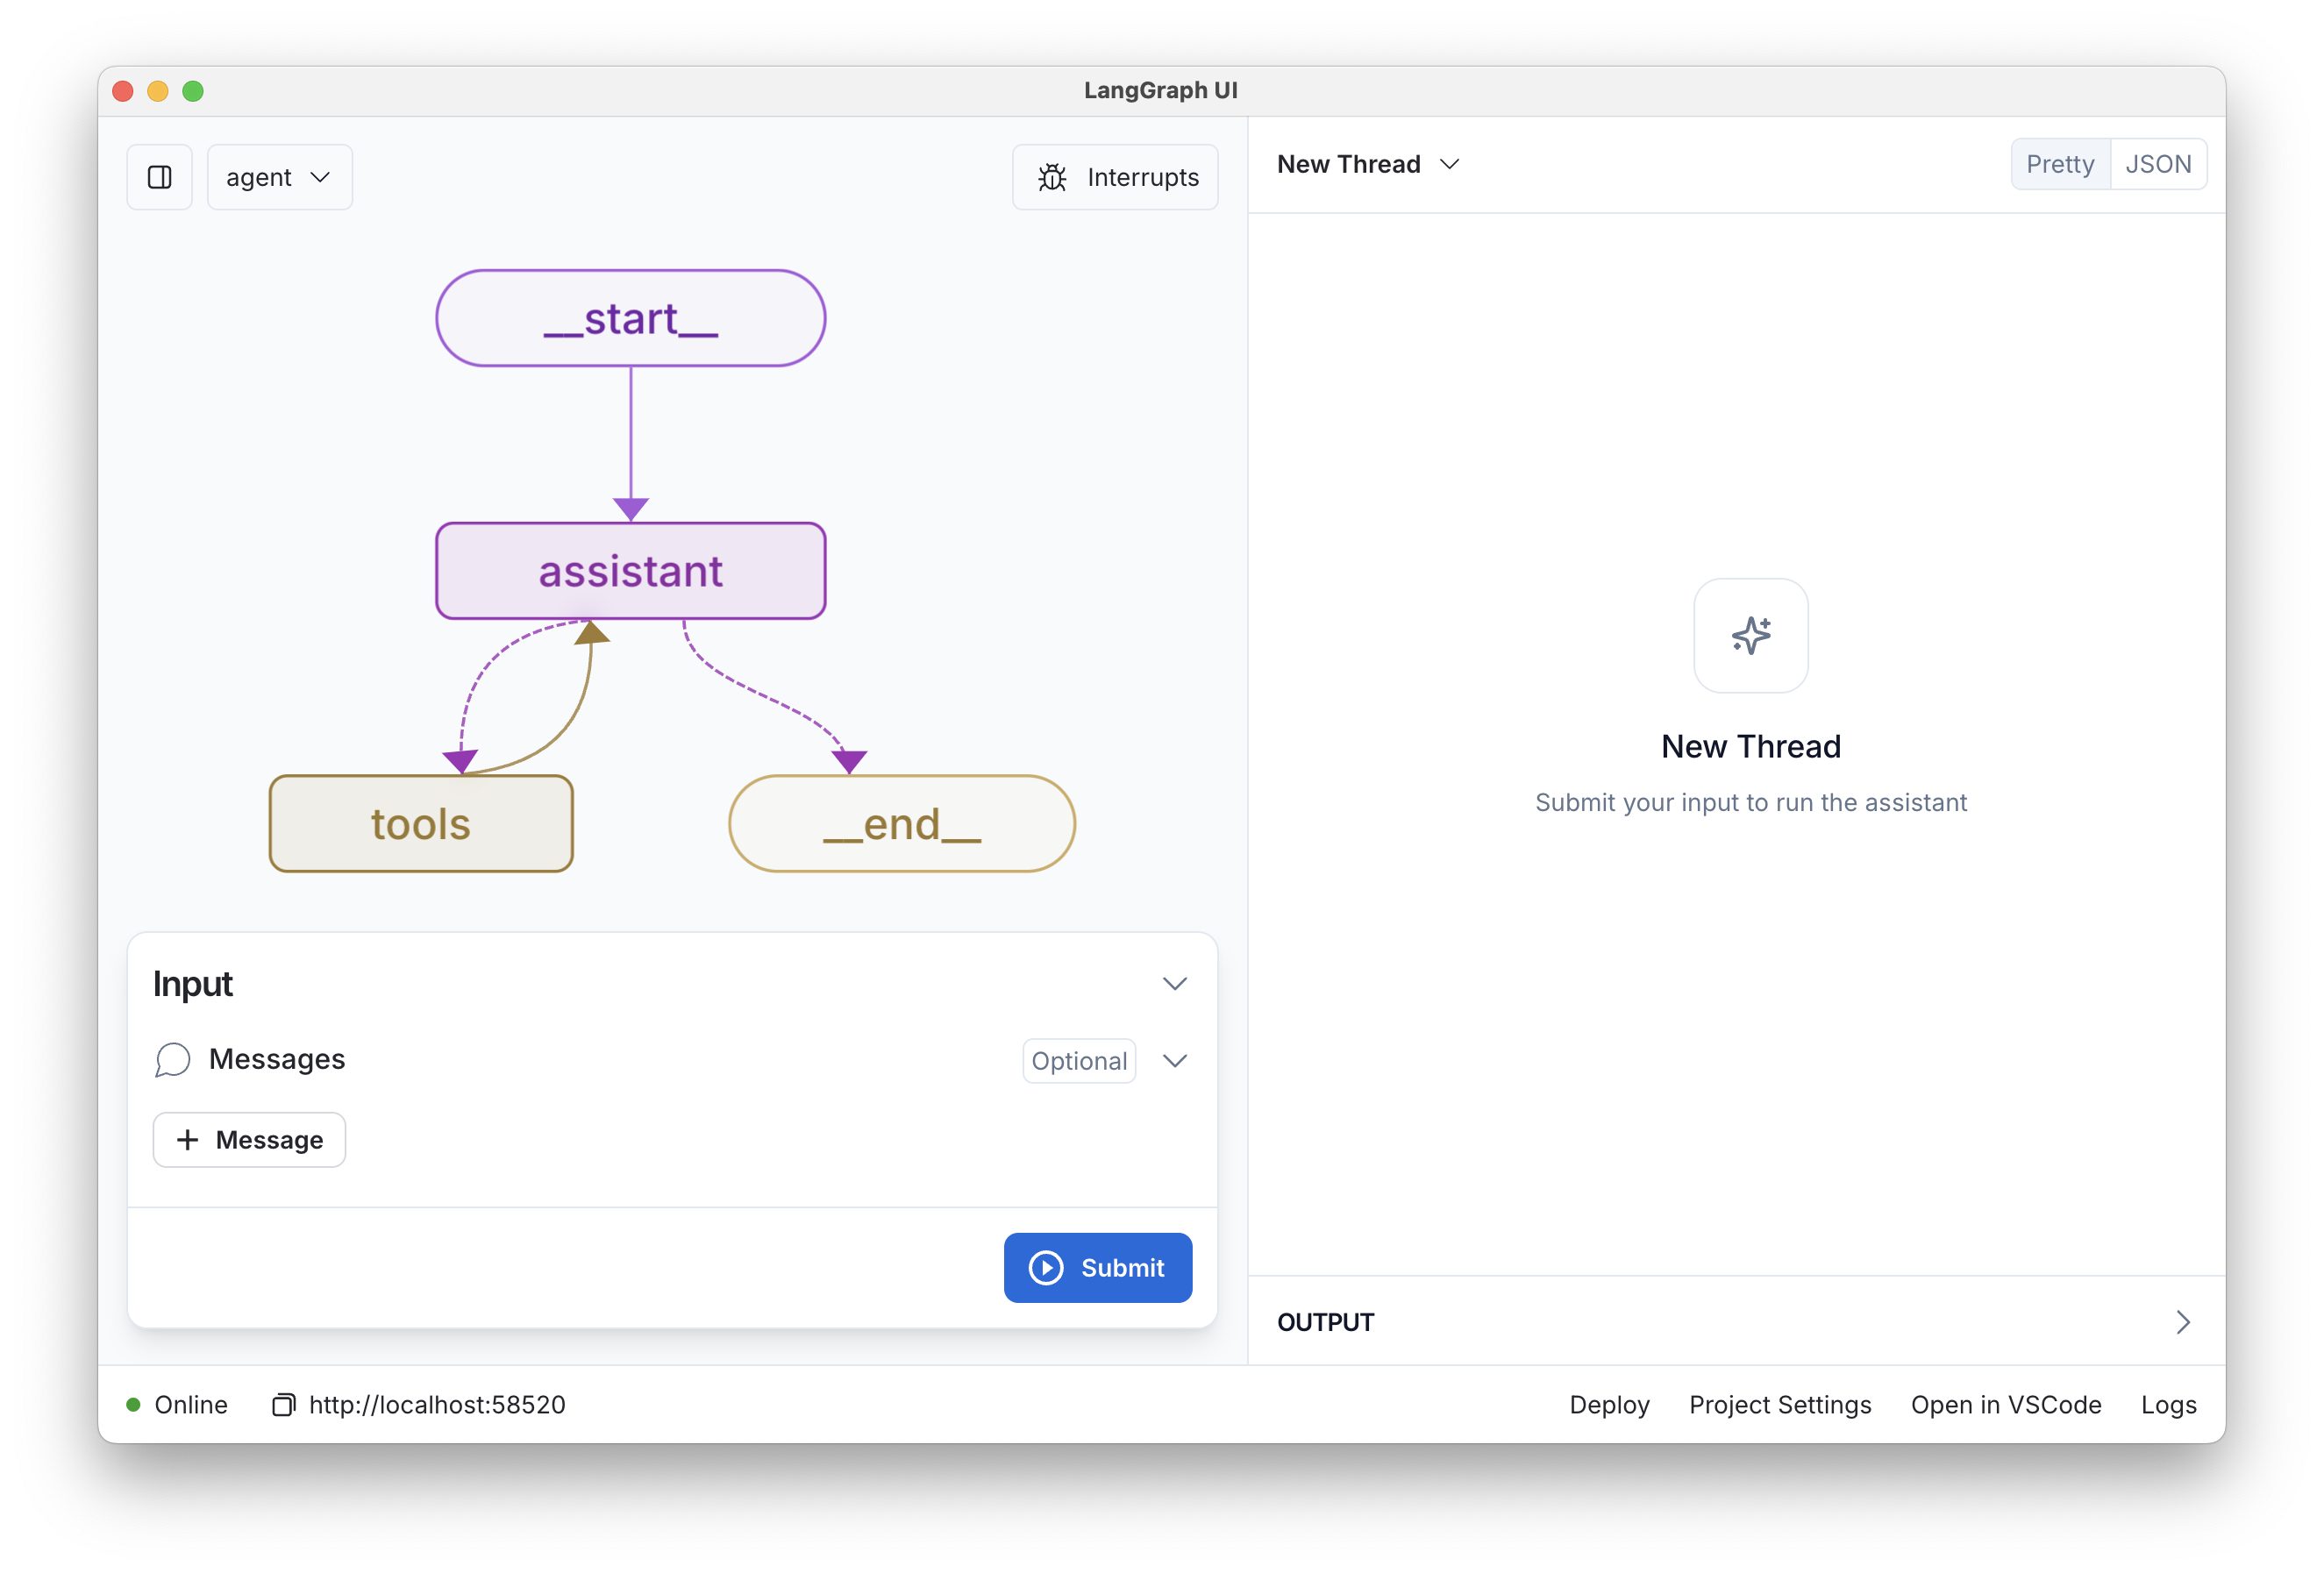

The LangGraph API [has first class support for streaming](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#streaming). 

In [ ]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:50813"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [10]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1ef67ddb-d81f-6e00-ba70-ee7f3100a906'})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '89592bb3-5095-4376-b30e-dd7c4d9c74d9', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '89592bb3-5095-4376-b30e-dd7c4d9c74d9', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_agvFnv31kJxThwHlcklgzgJA', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai'

The streamed objects have: 

* `event`: Type
* `data`: State

In [11]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} id='c80fb837-1f32-4225-bd79-8bfc3980a096'
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_xgQnq5tHxCaoU6TawuIACW5p', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': None} id='run-7f0b7d57-e49f-4850-b60d-2ccfa4d0e3f4' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_xgQnq5tHxCaoU6TawuIACW5p', 'type': 'tool_call'}]
content='6' additional_kwargs={'additional_kwargs': {}, 'response_metadata': {}, 'status': 'success'} name='multiply' id='2385b306-97d5-4476-831a-129f8c47a16f' tool_call_id='call_xgQnq5tHxCaoU6TawuIACW5p'
conte

There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph that is a list of messages.

All events emitted have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [12]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete


We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: LLM tokens

You can dig further into these type [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages)!

Now, let's show how to stream these messages. 

The nice thing is that we can get token-wise streaming of partial messages!

We'll define a helper function for better formatting of the tool calls in messages.

In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    elif event.event == "messages/partial":
        for data_item in event.data:
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
        print("-" * 50)

Metadata: Run ID - 1ef67de4-61b9-6b21-bfdc-a1c54afe1708
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Ho1AcKnzvdPk0cewPdIzmexO, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Ho1AcKnzvdPk0cewPdIzmexO, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Ho1AcKnzvdPk0cewPdIzmexO, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Ho1AcKnzvdPk0cewPdIzmexO, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Ho1AcKnzvdPk0cewPdIzmexO, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Ho1AcKnzvdPk0cewPdIzmexO, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal